In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.7 MB/s eta 0:00:00


# TRX-USD

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/TRX-USD.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index


## 7:2:1

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data =df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10799.776, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10804.672, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10803.055, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10802.932, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10806.438, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10801.031, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.798 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

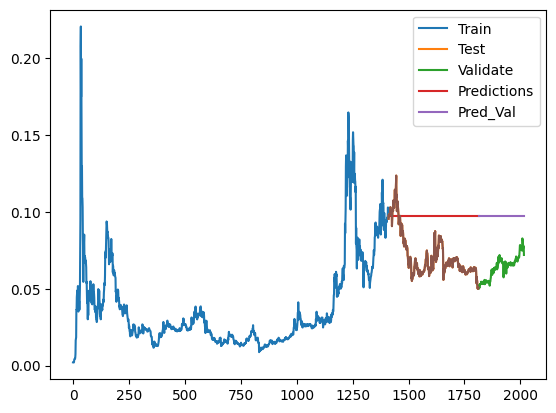

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
for i in range(len(y_next_7_days)):
    day = i + 1
    price = y_next_7_days[i]
    print(f"Day {day}: {price}")

Predicted closing prices for the next 7 days:
Day 1: 0.0971620008349418
Day 2: 0.0971620008349418
Day 3: 0.0971620008349418
Day 4: 0.0971620008349418
Day 5: 0.0971620008349418
Day 6: 0.0971620008349418
Day 7: 0.0971620008349418


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.033
Validation RMSE: 0.034
Validation MAPE: 54.299
Testing MAE: 0.027
Testing RMSE: 0.029
Testing MAPE: 41.365


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## 5:3:2

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

# 3. Quá trình Training
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])

In [ ]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=0.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=2.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=2.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=1.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=1.31 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
# 4. Quá trình testing
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
y_pred1 = model.predict(n_periods=len(y_test1))

# 5. Quá trình Validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
y_pred_val1 =  model.predict(n_periods=len(y_val1))

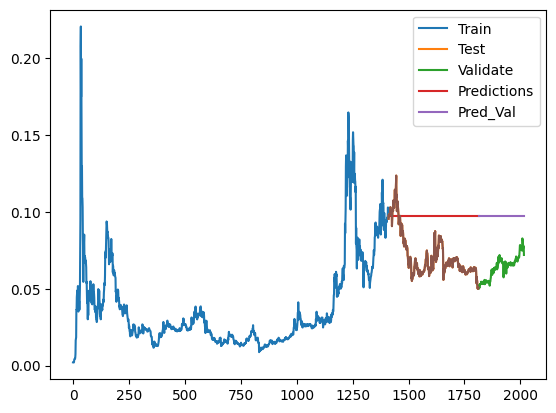

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()


In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index1 =  df.index[-1]
last_data1 = pd.RangeIndex(start=last_index1, stop=last_index1+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next1_7_days = np.array(range(last_index1+1, last_index1+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next1_7_days = model.predict(n_periods=len(x_next1_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next1_7_days)

Predicted closing prices for the next 7 days:
[0.04327661 0.04139114 0.04307232 0.04157865 0.04089122 0.04076675
 0.04076712]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính MAPE
def mean_absolute_percentage_error(y_true1, y_pred1):
    return np.mean(np.abs((y_true1 - y_pred1) / y_true1)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)

print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.017
Validation RMSE: 0.02
Validation MAPE: 25.642
Testing MAE: 0.023
Testing RMSE: 0.032
Testing MAPE: 33.778


## 6:2:2

In [ ]:
# 2. Chia train test validate theo tỉ lệ 6:2:2
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9544.714, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9487.923, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9491.907, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9491.566, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9489.817, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9548.913, Time=1.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9485.569, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9483.921, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9618.085, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9597.912, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9620.682, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9620.918, Time=1.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-9621.309, Time=1.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9541.259, Time=0.98 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

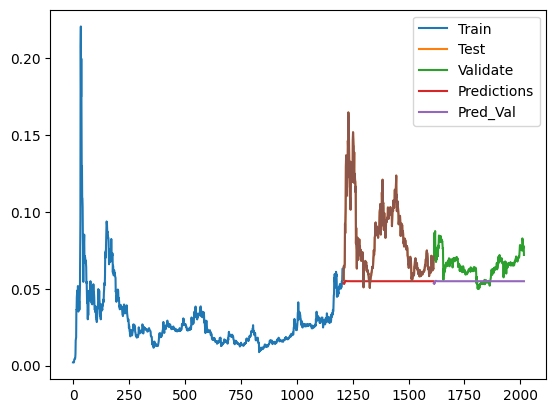

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[0.0536771  0.05406577 0.05315723 0.05348267 0.05416033 0.05415959
 0.05475567]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.011
Validation RMSE: 0.013
Validation MAPE: 15.528
Testing MAE: 0.028
Testing RMSE: 0.037
Testing MAPE: 29.546


In [ ]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)

# DOGE-USD

In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/DOGE-USD.csv')
df1 = df1[['Close']]
df1 = df1.dropna() # Drop missing values
df1 = df1.reset_index(drop=True) # Reset the index

## 7:2:1

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8187.891, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8161.669, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8182.490, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8178.693, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8163.460, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8211.213, Time=2.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8199.423, Time=2.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8183.319, Time=0.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8235.037, Time=1.51 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8237.062, Time=1.60 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8235.027, Time=1.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8239.603, Time=2.51 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-8270.552, Time=4.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8269.645, Time=2.32 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

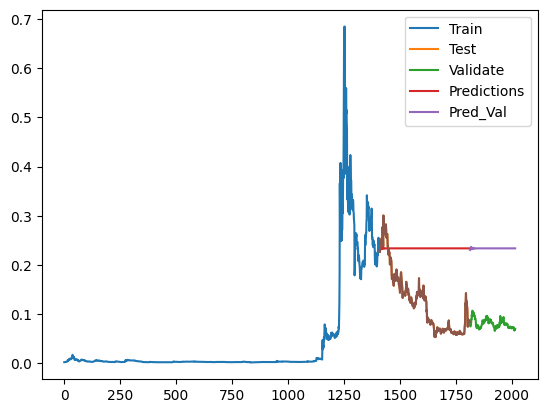

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[0.23046058 0.23126391 0.2312616  0.23537101 0.23593656 0.23498226
 0.23538516]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.153
Validation RMSE: 0.153
Validation MAPE: 192.462
Testing MAE: 0.114
Testing RMSE: 0.126
Testing MAPE: 137.832


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## 5:3:2

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1+test_size1]
val_data1 = df1[train_size1+test_size1:]

# 3. Quá trình Training
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])

In [ ]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13331.584, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13325.688, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13343.252, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13343.617, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13327.683, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13341.589, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13340.981, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13344.336, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13339.416, Time=1.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-13340.236, Time=0.93 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13319.537, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13336.925, Time=1.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-13346.107, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-13342.983, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13343.583, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-13333.709, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-13341.419, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13345.617, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-13342.243, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13321.541, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-13338.935, Time=0.61 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 9.882 seconds


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
y_pred1 = model.predict(n_periods=len(y_test1))

# 5. Quá trình Validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
y_pred_val1 =  model.predict(n_periods=len(y_val1))

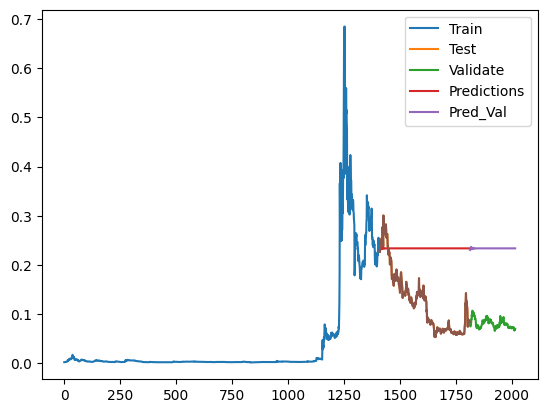

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()


In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index1 =  df.index[-1]
last_data1 = pd.RangeIndex(start=last_index1, stop=last_index1+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next1_7_days = np.array(range(last_index1+1, last_index1+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next1_7_days = model.predict(n_periods=len(x_next1_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next1_7_days)

Predicted closing prices for the next 7 days:
[0.00275903 0.00275847 0.00275894 0.00275855 0.00275888 0.0027586
 0.00275884]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính MAPE
def mean_absolute_percentage_error(y_true1, y_pred1):
    return np.mean(np.abs((y_true1 - y_pred1) / y_true1)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)

print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.075
Validation RMSE: 0.076
Validation MAPE: 96.333
Testing MAE: 0.15
Testing RMSE: 0.195
Testing MAPE: 79.616


## 6:2:2

In [5]:
# 2. Chia train test validate theo tỉ lệ 6:2:2
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12192.619, Time=4.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12141.786, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12143.452, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12142.508, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12142.986, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12187.800, Time=3.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11788.880, Time=3.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12239.650, Time=3.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12241.530, Time=1.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12243.491, Time=1.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12186.728, Time=0.43 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-12242.175, Time=1.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-12240.130, Time=3.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12244.668, Time=0.42 sec
 ARIM

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

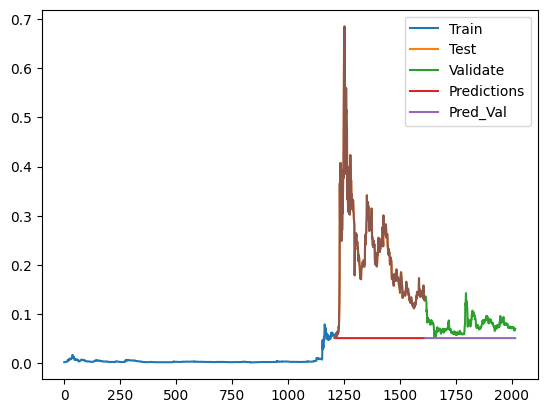

In [8]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [10]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df1.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[0.05149336 0.05151657 0.0511459  0.05110441 0.05117584 0.05110018
 0.05108018]


In [11]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.027
Validation RMSE: 0.03
Validation MAPE: 32.077
Testing MAE: 0.169
Testing RMSE: 0.196
Testing MAPE: 71.293


In [12]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)

# XLM-USD

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/XLM-USD.csv')
df2 = df2[['Close']]
df2 = df2.dropna() # Drop missing values
df2 = df2.reset_index(drop=True) # Reset the index

## 7:2:1

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6836.142, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6830.913, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6833.580, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6833.271, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6832.813, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6829.355, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6830.945, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6829.046, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6833.061, Time=1.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6831.979, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6840.285, Time=1.78 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6832.581, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6838.070, Time=2.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6833.382, Time=0.39 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

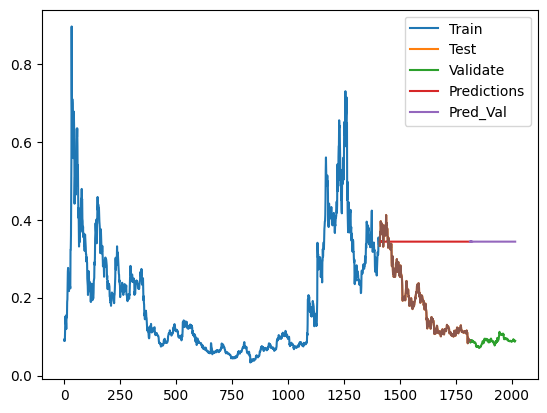

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[0.34370167 0.34298945 0.34433065 0.34319151 0.34415904 0.34333727
 0.34403524]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.255
Validation RMSE: 0.255
Validation MAPE: 290.214
Testing MAE: 0.16
Testing RMSE: 0.178
Testing MAPE: 120.219


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## 5:3:2

In [ ]:
# 2. Chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size1 = int(0.5 * len(df2))
test_size1 = int(0.3 * len(df2))
val_size1 = len(df2) - train_size1 - test_size1

train_data1 = df2[:train_size1]
test_data1 = df2[train_size1:train_size1+test_size1]
val_data1 = df2[train_size1+test_size1:]

# 3. Quá trình Training
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])

In [ ]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5086.695, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5090.100, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5088.997, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5088.932, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5092.100, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5086.102, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.765 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
y_pred1 = model.predict(n_periods=len(y_test1))

# 5. Quá trình Validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
y_pred_val1 =  model.predict(n_periods=len(y_val1))

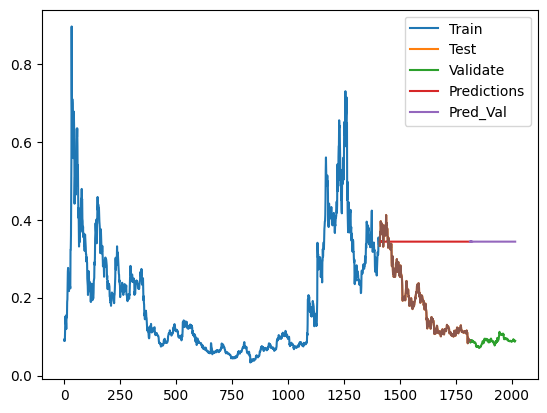

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index1 =  df.index[-1]
last_data1 = pd.RangeIndex(start=last_index1, stop=last_index1+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next1_7_days = np.array(range(last_index1+1, last_index1+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next1_7_days = model.predict(n_periods=len(x_next1_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next1_7_days)

Predicted closing prices for the next 7 days:
[0.079447 0.079447 0.079447 0.079447 0.079447 0.079447 0.079447]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính MAPE
def mean_absolute_percentage_error(y_true1, y_pred1):
    return np.mean(np.abs((y_true1 - y_pred1) / y_true1)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)

print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.024
Validation RMSE: 0.031
Validation MAPE: 21.459
Testing MAE: 0.204
Testing RMSE: 0.244
Testing MAPE: 62.529


## 6:2:2

In [ ]:
# 2. Chia train test validate theo tỉ lệ 6:2:2
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9544.714, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9487.923, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9491.907, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9491.566, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9489.817, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9548.913, Time=1.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9485.569, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9483.921, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9618.085, Time=0.68 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9597.912, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9620.682, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9620.918, Time=1.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-9621.309, Time=2.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9541.259, Time=2.38 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# 6. Quá trình tạo index predict 7 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[0.0536771  0.05406577 0.05315723 0.05348267 0.05416033 0.05415959
 0.05475567]


In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.011
Validation RMSE: 0.013
Validation MAPE: 15.528
Testing MAE: 0.028
Testing RMSE: 0.037
Testing MAPE: 29.546


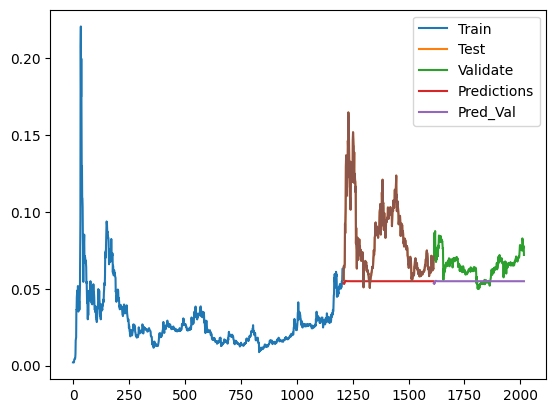

<Figure size 640x480 with 0 Axes>

In [ ]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(test_data.index, test_data['Close'])
# plt.plot(last_data,y_next_7_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Pred_Val'])
plt.show()
# Save the plot as an image
plt.savefig('XLM_622.png')

In [ ]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)